Predicting future number of claims made by policy holders is at the heart of every insurance company’s business model. 
In this blogpost, we will show you how to estimate future number of claims using generalized linear models (GLMs) in Julia.

We will work with the freMTPL2freq dataset, which contains insurance claims data from French policyholders of car insurances. Our goal is to model the relationship between policyholder characteristics and their expected number of claims per year — the claim frequency.

For a fresh perspective on this task, we will use Julia, a high-performance programming language tailored for numerical and scientific computing. Julia stands out by combining the execution speed of low-level languages like C with the intuitive syntax and ease of use typically associated with high-level languages like Python.

This blog post is structured into several sections. We will begin by loading the data, followed by exploring and visualizing key statistics from the dataset. Next, we will preprocess the data to prepare it for modeling. Finally, we will fit a generalized linear model to predict the claim frequency.

# Setup
Before we begin our analysis, we need to set up a working environment. Fortunately, Julia includes a built-in package manager, which greatly simplifies this process. The following commands will create a new local environment and install the necessary packages.

In [ ]:
import Pkg
Pkg.activate(".")
Pkg.add([
    "StatsBase",
    "Distributions",
    "ARFFFiles",
    "DataFrames",
    "CategoricalArrays",
    "Plots",
    "FileIO", "ImageIO",
    "LaTeXStrings",
    "GLM",
    "LossFunctions",
])
Pkg.instantiate()

The following code cell loads the required packages and sets some plotting defaults for the plotting package `Plots.jl`.

In [2]:
using StatsBase, Distributions, DataFrames, CategoricalArrays
using Random
using GLM, LossFunctions
using ARFFFiles
using Plots, FileIO, ImageIO, LaTeXStrings

default(
    fontfamily="Computer Modern",
    grid=:none,
    border=:box,
)

## Download the dataset

The dataset we are using is the `freMTPL2freq` dataset.
The `freMTPL2freq` dataset contains risk features for 677,991 motor third-party liability policies, observed over one year. It is described in *Computational Actuarial Science with R* (Arthur Charpentier, CRC, 2018) and is available on [OpenML](https://www.openml.org/search?type=data&sort=runs&id=41214&status=active). The following command will automatically download the dataset from OpenML, if it isn't already available in the current working directory:

In [3]:
file_path = "freMTPL2freq.arff"
if !isfile(file_path)
    using Downloads
    Downloads.download("https://www.openml.org/data/download/20649148/freMTPL2freq.arff", file_path)
end

The dataset is in the ARFF format. We will use the `ARFFFiles` package to load the data into a `DataFrame` and show its first 7 rows.

In [ ]:
df = ARFFFiles.load(DataFrame, file_path)
first(df, 7) # show the first 7 lines

7×12 DataFrame
 Row │ IDpol    ClaimNb  Exposure  Area  VehPower  VehAge   DrivAge  BonusMalu ⋯
     │ Float64  Float64  Float64   Cat…  Float64   Float64  Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1.0      1.0      0.1   D          5.0      0.0     55.0        50. ⋯
   2 │     3.0      1.0      0.77  D          5.0      0.0     55.0        50.
   3 │     5.0      1.0      0.75  B          6.0      2.0     52.0        50.
   4 │    10.0      1.0      0.09  B          7.0      0.0     46.0        50.
   5 │    11.0      1.0      0.84  B          7.0      0.0     46.0        50. ⋯
   6 │    13.0      1.0      0.52  E          6.0      2.0     38.0        50.
   7 │    15.0      1.0      0.45  E          6.0      2.0     38.0        50.
                                                               5 columns omitted

The content of some of the columns, such as `IDpol` (the policy id) or `ClaimNb` (the number of claims), is incorrectly recognized as floating point numbers, but are actually integer valued. We will convert them to integers. This is not strictly necessary but visually much more appealing.

In [36]:
df[!,:IDpol] = convert.(Int, df[!,:IDpol])
df[!,:ClaimNb] = convert.(Int, df[!,:ClaimNb])
first(df, 7)

7×12 DataFrame
 Row │ IDpol  ClaimNb  Exposure  Area  VehPower  VehAge   DrivAge  BonusMalus  ⋯
     │ Int64  Int64    Float64   Cat…  Float64   Float64  Float64  Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1        1      0.1   D          5.0      0.0     55.0        50.0  ⋯
   2 │     3        1      0.77  D          5.0      0.0     55.0        50.0
   3 │     5        1      0.75  B          6.0      2.0     52.0        50.0
   4 │    10        1      0.09  B          7.0      0.0     46.0        50.0
   5 │    11        1      0.84  B          7.0      0.0     46.0        50.0  ⋯
   6 │    13        1      0.52  E          6.0      2.0     38.0        50.0
   7 │    15        1      0.45  E          6.0      2.0     38.0        50.0
                                                               4 columns omitted

Users new to Julia, please note the dot syntax above. The dot syntax indicates that the `convert` function is applied elementwise to the selected columns of the dataframe `df`.

## Description of columns

The `freMTPL2freq` dataset contains tabular data arranged in the following columns:

| Column        | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| IDpol        | The policy ID, which uniquely identifies policy holders.                                                             |
| ClaimNb      | Number of claims during the exposure period.                                |
| Exposure     | The time the insurance policy was held in the specific year.                |
| Area         | The area code.                                                              |
| VehPower     | The power of the car (ordered categorical).                                 |
| VehAge       | The vehicle age, in years.                                                  |
| DrivAge      | The driver age, in years (in France, people can drive a car from age 18).         |
| BonusMalus   | Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus. |
| VehBrand     | The car brand (unknown categories).                                         |
| VehGas       | The car gas. Either Diesel or regular.                                      |
| Density      | The density of inhabitants (number of inhabitants per km²) in the city the driver lives in. |
| Region       | The policy regions in France (based on a standard French classification).    |


# Visualizing the dataset

## Histograms of policy holder features

A common first step in understanding a dataset is to examine histograms. These visualizations can reveal irregularities, such as outliers or unreasonable values, as well as potentially useful data transformations.

In this and the upcoming sections, the code used to generate plots will be hidden by default. If you wish to view the code, simply click the `Code` button to expand it.

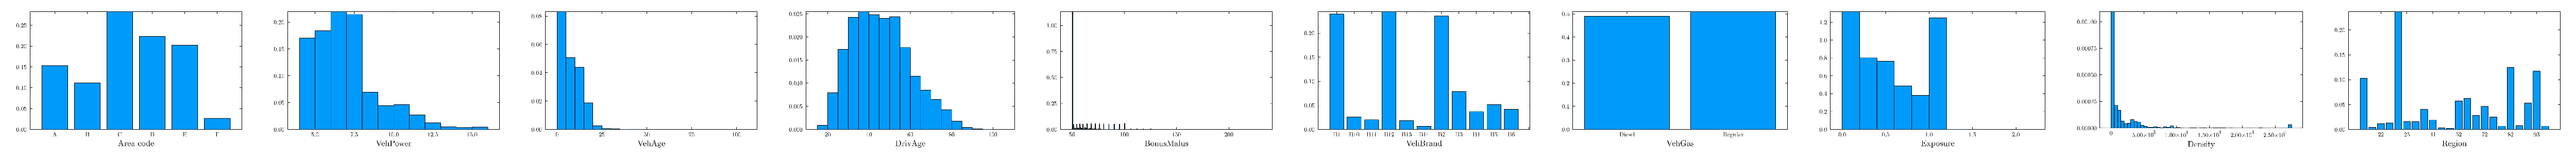

In [5]:
#| code-fold: true
let 
    gr()
    regions = map(s-> string(s)[2:3], df.Region)
    plot_size = (500,300)
    dpi = 300
    
    # Create a list of IOBuffer instances for each plot
    io_buffers = [IOBuffer() for _ in 1:10]

    plot(bar(sort(proportionmap(df.Area))); xlabel="Area code", label="", legend=:none, size=plot_size, dpi=dpi)
    png(io_buffers[1])

    plot(histogram(df.VehPower; bins=15, normalize=:pdf, xlabel="VehPower", label="", size=plot_size, dpi=dpi))
    png(io_buffers[2])

    plot(histogram(df.VehAge; bins=20, normalize=:pdf, xlabel="VehAge", label="", size=plot_size, dpi=dpi))
    png(io_buffers[3])

    plot(histogram(df.DrivAge; normalize=:pdf, bins=20, xlabel="DrivAge", label="", size=plot_size, dpi=dpi))
    png(io_buffers[4])

    plot(histogram(df.BonusMalus; normalize=:pdf, xlabel="BonusMalus", label="", size=plot_size, dpi=dpi))
    png(io_buffers[5])

    plot(bar(proportionmap(df.VehBrand); xlabel="VehBrand", label="", size=plot_size, dpi=dpi))
    png(io_buffers[6])

    plot(bar(proportionmap(df.VehGas); xlabel="VehGas", label="", size=plot_size, dpi=dpi))
    png(io_buffers[7])

    plot(histogram(df.Exposure; bins=10, normalize=:pdf, xlabel="Exposure", label="", size=plot_size, dpi=dpi))
    png(io_buffers[8])

    plot(histogram(df.Density; bins=100, normalize=:pdf, xlabel="Density", label="", size=plot_size, dpi=dpi))
    png(io_buffers[9])

    plot(bar(sort(proportionmap(regions)); label="", xlabel="Region", size=plot_size, dpi=dpi))
    png(io_buffers[10])

    plot((plot(load(io)) for io in io_buffers)...;
        axis=nothing,
        border=:none,
        layout=(1,10),
        size=(500*10,300),
        label="",
    )
end

Use the horizontal slider to navigate through the histograms of various policyholder properties.

Based on these histograms, we can make the following observations:

- **VehAge** exhibits a long tail, with some vehicle ages extending up to 100.  
- **BonusMalus** is sharply peaked at 50 and at certain integer values up to 100, with only a few values exceeding 100.  
- There are **Exposure** values that exceed 1.  
- **Density** is skewed towards and peaked at zero, with a potential exponentially decaying tail.  

These observations suggest the following:  

- Extremely high vehicle ages may be erroneous.  
- Exposure values greater than 1 are likely mislabeled, as the dataset exclusively contains one year's insurance data.  
- Density may be more appropriately modeled as a logarithmic variable.

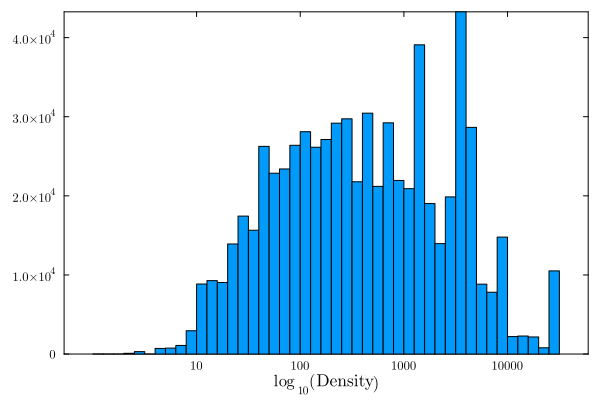

In [6]:
#| code-fold: true
histogram(log10.(df.Density); 
	bins=50, 
	xticks=(collect(1:4), [10, 100, 1000, 10000]),
    label="",
    xlabel=L"$\log_{10}($Density$)$"
)

Indeed, the density seems more tightly concentrated on a logarithmic scale.

## Correlations of the features

In the following analysis, we will investigate the correlations between numerical features in the dataset to better understand their relationships. An important tool for this task is the Spearman correlation coefficient.

### Spearman correlation coefficient

The Spearman correlation coefficient ($\rho$) measures the strength and direction of the relationship between two variables based on their ranks, rather than their actual values. It shows how well one variable can be described as increasing or decreasing consistently with the other, even if the relationship is not linear.

**Interpretation**

- $\rho = 1$ : Perfect positive correlation.
- $\rho = -1$ : Perfect negative correlation.
- $\rho = 0$ : No correlation.


::: {.callout-tip collapse="true"}
## The Spearman correlation coefficient in mathematical formulas
The Spearman correlation coefficient is the correlation between the ranks of two data series $(X_i)_i$ and $(Y_i)_i$. Equivalently, it is the Pearson correlation coefficient between the rank variables of $(X_i)_i$ and $(Y_i)_i$. In formula, it can be expressed as

$$ \rho = \frac{\operatorname{cov}(R[X], R[Y])}{\sigma_{R[X]} \sigma_{R[Y]}} $$

where:

- the rank function $R$ assigns to each value $X_i$ its position (rank) in the ordered collection of $X_i$'s. E.g., for $X_1=0.3$, $X_2=1.2$ and $X_3=-0.1$ the ranks $R$ are $R[X_1]=2$, $R[X_2]=3$ and $R[X_3]=1$. They are the positions of the values $X_i$ in the sorted list of $X_i$'s.
- $\operatorname{cov}(R[X], R[Y])$ denotes the covariance between the sequences $R[X_i]$ and $R[Y_i]$
  $$ \operatorname{cov}(R[X], R[Y]) = \frac{1}{n-1} \sum_i (R[X_i] - \mu_{R[X]})(R[Y_i] - \mu_{R[Y]})$$
  with $\mu_{R[X]}$ and $\mu_{R[Y]}$ being the mean of the ranks and $n$ the number of observations.
- $\sigma_{R[X]}$ and $\sigma_{R[Y]}$ are the standard deviations of the ranks of $X$ and $Y$, respectively. They are calculated as
  $$ \sigma_{R[X]} = \sqrt{\frac{1}{n-1} \sum_i (R[X_i] - \mu_{R[X]})^2}.$$
:::

Using the Spearman coefficient excludes the possibility of analyzing correlations involving categorical variables. Therefore, we limit the analysis to numerical features, with the exception of the area code. We hypothesize that the area codes might be associated with the population density in those regions; however, this is currently just an assumption. To test this hypothesis, we will assign numerical values to the area codes A-F, enumerating them as 1 through 6. 

In [7]:
area_as_int = [
    findfirst(l->l==areacode, ["A", "B","C","D","E","F"]) 
    for areacode in df.Area
];

The features **VehGas**, **VehicleBrand**, and **Region** are categorical and will be excluded from the correlation matrix.

Let us calculate the Spearman correlation coefficients of all pairs of numerical features utilizing the `corspearman` function from the `StatsBase` package. We collect the pairwise coefficients in a matrix. This resulting matrix is symmetric as the correlations between $X$ and $Y$ are the same as between $Y$ and $X$. This follows directly from the definition of the correlation coefficient.

In [8]:
feature_corspearman = let
	features = [:VehPower, :VehAge, :DrivAge, :BonusMalus, :Density]
	coefs = zeros(length(features)+1, length(features)+1)

	for j in eachindex(features)
		coefs[1,j+1] = corspearman(df[!,features[j]], area_as_int)
	end
	
	for i in 1:length(features)
		for j in 1:length(features)
			i >= j && continue
			coefs[i+1,j+1] = corspearman(df[!,features[i]], df[!,features[j]])
		end
	end
	coefs = round.(coefs, digits=2)
	coefs += coefs'
	for i in 1:size(coefs,1)
		coefs[i,i] = 1
	end
	coefs
end

6×6 Matrix{Float64}:
  1.0   -0.01  -0.1   -0.05   0.14   0.98
 -0.01   1.0    0.0    0.04  -0.07  -0.01
 -0.1    0.0    1.0   -0.08   0.08  -0.1
 -0.05   0.04  -0.08   1.0   -0.57  -0.04
  0.14  -0.07   0.08  -0.57   1.0    0.14
  0.98  -0.01  -0.1   -0.04   0.14   1.0

We visualize this matrix as a heatmap. The heatmap is symmetric along the diagonal, with the diagonal elements being equal to 1. The color of each cell represents the strength and direction of the correlation between the corresponding pair of features.

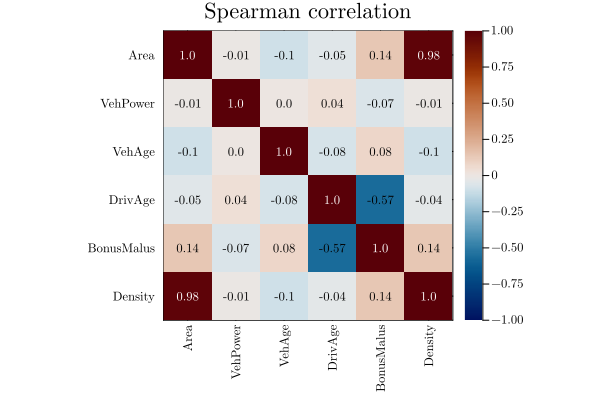

In [9]:
#| code-fold: true

let
    tick_labels = ["Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
    n = length(tick_labels)
    heatmap(feature_corspearman;
        color=:vik,
        clims=(-1,1),
        ticks=(eachindex(tick_labels), tick_labels),
        title="Spearman correlation",
        xrot=90,
        yflip=true,
    )
    for i in 1:n, j in 1:n
        color = abs(feature_corspearman[i,j]) > 0.8 ? :white : :black
        annotate!(i,j, text(round(feature_corspearman[i,j],digits=3), 8,"Computer Modern",color))
    end
    plot!(
        aspectratio=1,
        lims=(0.5, n+0.5),
        bottommargin=5Plots.PlotMeasures.mm,
    )
end

The spearman table reveals a positive correlation between area and density and a negative corrleation between driver age and BonusMalus. The correlation between the other features is weak. Next, we will visualize the correlation between the area and the density as well as the driver age and the BonusMalus.

### Correlations visualized

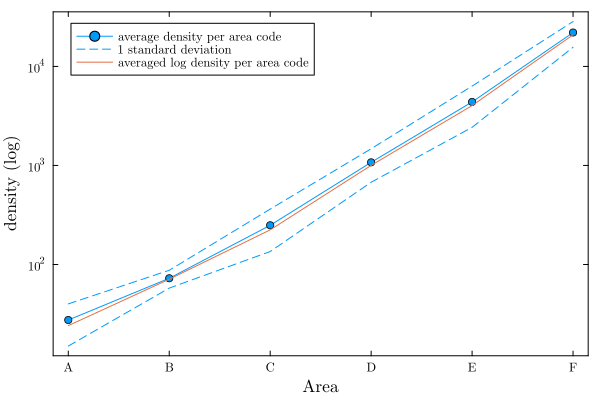

In [10]:
#| code-fold: true

let df = df
	df = select(df, :Area, :Density)
	df = groupby(df, :Area)
	df = combine(df,
		:Density=>mean,
		:Density=>std,
		:Density=>(c->exp(mean(log, c)))=>:Density_log_mean, 
	)
	sort!(df)
	
	plot(df.Area, df.Density_mean;
		marker=:circle,
		label="average density per area code",
	)
	plot!(df.Area, df.Density_mean .+ df.Density_std; label="1 standard deviation", color=1, ls=:dash)
	plot!(df.Area, df.Density_mean .- df.Density_std; label="", color=1, ls=:dash)

	plot!(df.Area, df.Density_log_mean; label="averaged log density per area code", color=2)
	plot!(
		yscale=:log10,
		xlabel="Area",
		ylabel="density (log)",
	)
	
end

We observe that the $log$(**density**) is linearly increasing with the area code. Hence, our initial guess was correct and the area code is mainly determined by the density of people living in that area.

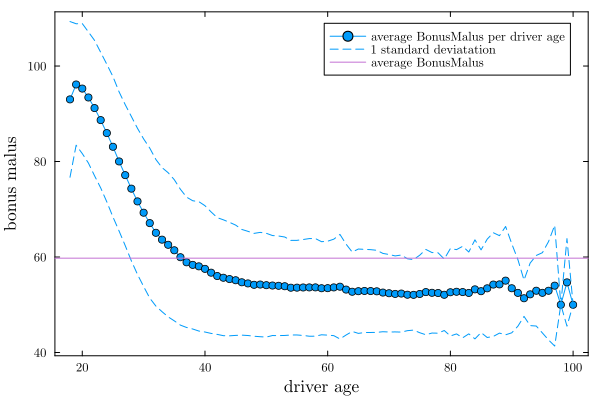

In [11]:
#| code-fold: true

let df = df

    avrg_bonus_malus = mean(df.BonusMalus)
	df = select(df, :DrivAge, :BonusMalus)
	df = groupby(df, :DrivAge)
	df = combine(df,
		:BonusMalus=>mean,
		:BonusMalus=>std,
	)
	plot(df.DrivAge, df.BonusMalus_mean;
		marker=:circle,
		label="average BonusMalus per driver age",
	)
	plot!(df.DrivAge, df.BonusMalus_mean .+ df.BonusMalus_std; label="1 standard deviatation", color=1, ls=:dash)
	plot!(df.DrivAge, df.BonusMalus_mean .- df.BonusMalus_std; label="", color=1, ls=:dash)
	hline!([avrg_bonus_malus]; label="average BonusMalus")
	plot!(
		xlabel="driver age",
		ylabel="bonus malus",
	)
end

The driver age is negatively correlated with the **BonusMalus**. This is also expected, as the **BonusMalus** is a measure of the driver's driving history. The older the driver, the longer they typically hold the insurance and, providing no claims have been made, the lower the **BonusMalus**.

## Distribution of the predicted variable

Our goal in this notebook is to predict the number of claims **ClaimNb** per year as a function of to be chosen features. Claims from different policy holders are (to a very good approximation) independent of each other. Hence, the distribuion of **ClaimNb** is typically considered Poissonian. We will check this by plotting a histogram of the **ClaimNb** values.

The Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time. It is defined by the rate parameter $\lambda$ which is the average number of events in the interval. In our case, it is the average number of claims per year.

In [12]:
poisson = Poisson(mean(df.ClaimNb))

Poisson{Float64}(λ=0.05324676665491664)

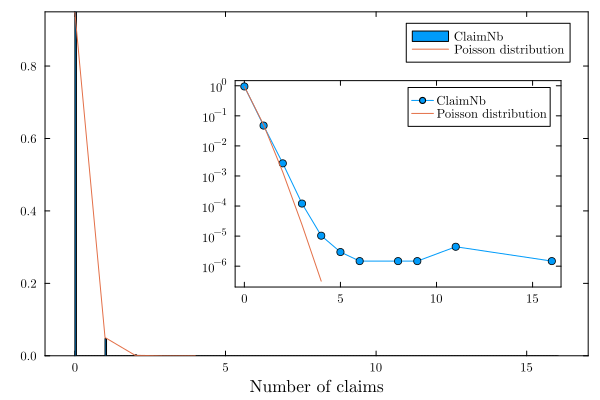

In [13]:
#| code-fold: true
histogram(df.ClaimNb; 
    normalize=:probability,
    label="ClaimNb",
    xlabel="Number of claims",
    binwidth=20,
)
plot!(0:4, pdf.(poisson, (0:4));
    label="Poisson distribution",
)

plot!(proportionmap(df.ClaimNb);
    inset=(1, bbox(0.35, 0.2, 0.6, 0.6)),
    subplot=2,
    marker=:circle,
    label="ClaimNb",
)
plot!(0:4, pdf.(poisson, (0:4)); 
    subplot=2,
    label="Poisson distribution",
    yscale=:log10
    )

The number of claims per year **ClaimNb** is very well approximated by a Poisson distribution for small number of claims. For larger numbers of claims, the Poisson distribution is not a good approximation. We actually observe that the tail is not exponential but flattens out. Because the number of claims are only collected over an exposure period of maximmally one year, large number of claims should be treatened with caution. In fact, the ratio between policy holders with more than 4 vs. policy holders with any (non-zero) number of claims is less than 0.03%:

In [14]:
sum(df.ClaimNb .> 4) / sum(df.ClaimNb .> 0) * 100

0.026423957721667647

These excessive numbers of claims might be due to mislabeled data or fraud.

## Frequency as a function of the features

We aim to model the frequency of claims as a function of the features. To build an intuition about the relationship between the features and the frequency, we will visualize the frequency as a function of each feature. 

To begin with, the portfolio frequency is:

In [15]:
portfolio_frequency = sum(df.ClaimNb) / sum(df.Exposure)

0.10070308464041308

Next, we will plot the frequency as a function of the $log$(**density**), **Area** and **BonusMalus**.

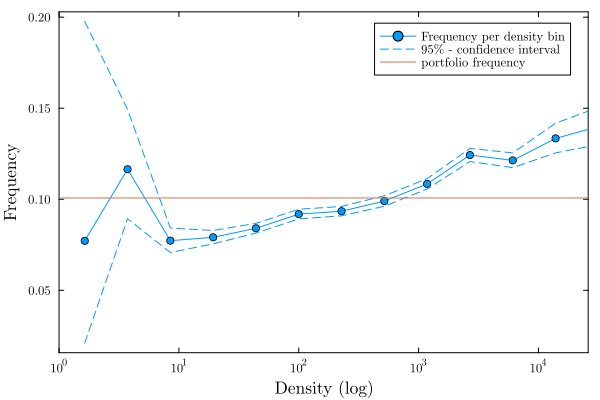

In [16]:
#| code-fold: true
let df = df


	"""
	confint_poisson(n, t)

	n :: number of observations

	t :: total time at risk
	"""
	function confint_poisson(n::Integer, t::Real)

		if n == 0
			return zero(t), zero(t)
		else
			l = quantile(Chisq(2*n), 0.025)/2 / t
			u = quantile(Chisq(2*n+2), 0.975)/2 / t
		end

		l, u
	end

	df = select(df, :Density, :ClaimNb, :Exposure)

	# Bin the density data into 15 bins on a log scale
	fmt(from, to, i; leftclosed, rightclosed) = (from + to)/2
	df.density_bin = cut(df.Density, 10 .^ range(0,5,length=15), labels=fmt)

	# Calculate the frequency for each bin
	# as the total claims divided by the total exposure
	df = groupby(df, :density_bin)
	df = combine(df, :ClaimNb=>sum, :Exposure=>sum)
	df.Frequency_bin = df.ClaimNb_sum ./ df.Exposure_sum

	xvalues = unwrap.(df.density_bin)
	plot(xvalues, df.Frequency_bin;
		marker=:circle,
		label="Frequency per density bin",
	)

	# Calculate the confidence intervals 
	confints = confint_poisson.(df.ClaimNb_sum, df.Exposure_sum)
	plot!(xvalues, [c[1] for c in confints];
		color=1,
		ls=:dash,
		label="95% - confidence interval",
	)
	plot!(xvalues, [c[2] for c in confints];
		color=1,
		ls=:dash,
		label="",
	)

	hline!([portfolio_frequency],
		color=2,
		label="portfolio frequency"
	)

	plot!(
		xscale=:log10, 
		xlims=(1, 26000), 
		xlabel="Density (log)",
		ylabel="Frequency",
	)
	
end

The frequency of claims appears to increase linearly with the $log$(**density**) for values of **density** greater than 10. However, caution is required when interpreting the very small **density** values, as indicated by the large error bars represented by the dashed line.

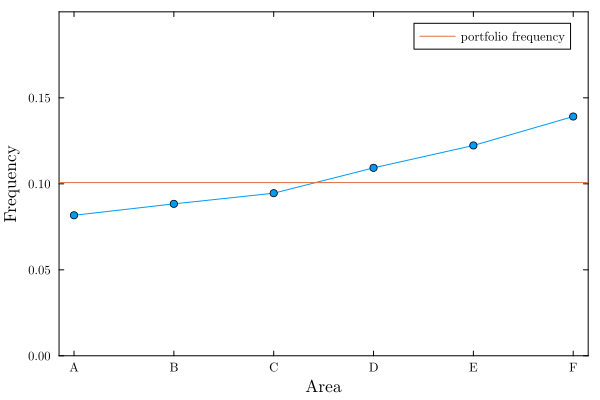

In [17]:
#| code-fold: true

let df = df
	df = select(df, :Area, :ClaimNb, :Exposure)
	df = groupby(df, :Area)
	df = combine(df,:ClaimNb=>sum, :Exposure=>sum)
	df.Frequency_mean_bin = df.ClaimNb_sum ./ df.Exposure_sum 
	sort!(df)
	plot(df.Area, df.Frequency_mean_bin;
		marker=:circle,
		label="",
	)

	hline!([portfolio_frequency],
		color=2,
		label="portfolio frequency"
	)

	
	plot!(
        ylims=(0,0.2),
		xlabel="Area",
		ylabel="Frequency",
	)
	
end

The frequency appears to increase with the area code (interpreted as ordinal variable with values 1 to 6) as well.

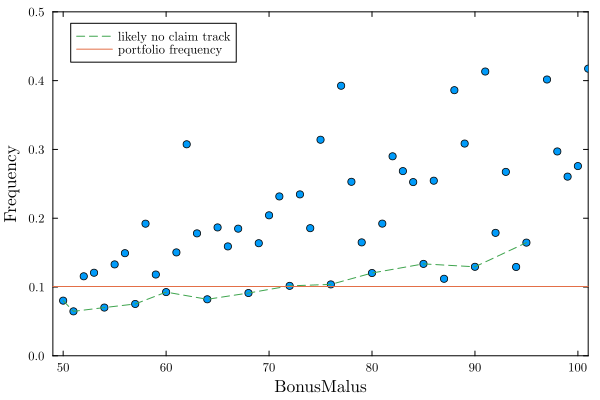

In [18]:
#| code-fold: true
let df = df

	bms = [100]
    for i in 1:13
        push!(bms, max.(floor(Int, 0.95*bms[i]), 50))
    end
    no_claim_bms = reverse(bms[2:end])
	
	df = select(df, :BonusMalus, :ClaimNb, :Exposure)
	df = groupby(df, :BonusMalus)
	df = combine(df,:ClaimNb=>sum, :Exposure=>sum)
	df.Frequency_mean_bin = df.ClaimNb_sum ./ df.Exposure_sum 
	sort!(df)
	scatter(df.BonusMalus, df.Frequency_mean_bin;
		marker=:circle,
		label="",
	)

	plot!(no_claim_bms, [df.Frequency_mean_bin[findfirst(x->x==bm, df.BonusMalus)] for bm in no_claim_bms];
		label="likely no claim track",
		color=3,
		ls=:dash,
	)
	

	hline!([portfolio_frequency]; label="portfolio frequency", color=2)
	plot!(
        ylims=(0,0.5),
        xlims=(49, 101),
		xlabel="BonusMalus",
		ylabel="Frequency",
	)
	
end

We observe a slight increase of the frequency with BonusMalus. But the datapoints are very scattered. The reason why most of the datapoints are above the portfolio frequency is that most policy holders have a BonusMalus of 50. Hence, the leftmost datapoint has very high weight and is below the portfolio frequency.

The green dashed line indicates drivers, which have not made a claim during their exposure period. In a follow up blog post I will show how to find out these policy holders and that these drivers have smaller frequency than the remainder. The key observation in the follow up blog post is that BonusMalus - in contrast to the other features - **does** contain information about the frequency of claims of the past years. Stay tuned!

# Preprocess the dataset

## Prune the dataset

Based on our analysis in the previous section, we will preprocess the dataset in the following way:

| Preprocessing Step | Justification |
|--------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| Map the area code to integers              | We observed a strong correlation between the area codes mapped to integers between 1-6 and the corresponding population density. |
| Cap the vehicle age at 25                  | There are only very few vehicle ages above 25. These are either mislabeled data or historic cars, which are typically used differently than regular cars. |
| Cap the exposure at 1                      | The whole dataset only contains insurance data of one year. The exposure values greater than 1 are mislabeled data. |
| Cap the claim numbers at 4 | Less than 0.03 % of policy holders have more than 4 claims per year. Some of these might be mislabeled data. |


In [19]:
df.Area = area_as_int
df.VehAge = min.(25, df.VehAge)
df.Exposure = min.(1, df.Exposure)
df.ClaimNb = min.(4, df.ClaimNb)
df

678013×12 DataFrame
    Row │ IDpol    ClaimNb  Exposure    Area   VehPower  VehAge   DrivAge  Bon ⋯
        │ Int64    Int64    Float64     Int64  Float64   Float64  Float64  Flo ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │       1        1  0.1             4       5.0      0.0     55.0      ⋯
      2 │       3        1  0.77            4       5.0      0.0     55.0
      3 │       5        1  0.75            2       6.0      2.0     52.0
      4 │      10        1  0.09            2       7.0      0.0     46.0
      5 │      11        1  0.84            2       7.0      0.0     46.0      ⋯
      6 │      13        1  0.52            5       6.0      2.0     38.0
      7 │      15        1  0.45            5       6.0      2.0     38.0
      8 │      17        1  0.27            3       7.0      0.0     33.0
   ⋮    │    ⋮        ⋮         ⋮         ⋮       ⋮         ⋮        ⋮         ⋱
 678007 │ 6114324        0  0.00547945      4      11.0      0.0     41.0      ⋯
 678008 │ 6114325        0  0.00547945      5       6.0      4.0     40.0
 678009 │ 6114326        0  0.00273973      5       4.0      0.0     54.0
 678010 │ 6114327        0  0.00273973      5       4.0      0.0     41.0
 678011 │ 6114328        0  0.00273973      4       6.0      2.0     45.0      ⋯
 678012 │ 6114329        0  0.00273973      2       4.0      0.0     60.0
 678013 │ 6114330        0  0.00273973      2       7.0      6.0     29.0
                                               5 columns and 677998 rows omitted

## Split into training and test set
It is very important to not split the dataset into training and test set before doing any data preprocessing. Otherwise, we might introduce a bias in the model. We will split the dataset into a training and a test set with a ratio of 80:20.

In [20]:
df_train, df_test = let
	
	idxs = shuffle!(collect(axes(df, 1)))
	idx_split = ceil(Int, length(idxs) * 0.8)
	df[idxs[1:idx_split],:], df[idxs[idx_split+1:end],:]
end

(542411×12 DataFrame
    Row │ IDpol    ClaimNb  Exposure  Area   VehPower  VehAge   DrivAge  Bonus ⋯
        │ Int64    Int64    Float64   Int64  Float64   Float64  Float64  Float ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 3151433        0      0.51      1       7.0      3.0     49.0        ⋯
      2 │ 3213399        1      0.64      3      10.0      7.0     46.0
      3 │ 1044219        0      1.0       6       4.0     15.0     64.0
      4 │ 4035567        0      0.61      5       5.0      1.0     51.0
      5 │ 4044984        0      0.9       3       4.0      0.0     43.0        ⋯
      6 │ 1195413        0      0.49      5       9.0      3.0     35.0
      7 │ 2122535        0      1.0       3       8.0     10.0     39.0
      8 │ 2110683        0      0.64      6      15.0      1.0     28.0
   ⋮    │    ⋮        ⋮        ⋮        ⋮       ⋮         ⋮        ⋮         ⋮ ⋱
 542405 │ 4046999        0      0.9       1       8.0      2.

# Train regression model

In this section, we will train a Poisson regression model to predict the number of claims per year per policy holder. We will use the `GLM` package to fit the model. The Poisson regression model is a generalized linear model (GLM) with a Poisson distribution and a log link function. 

## Base model

Before engineering a sophisticated model, we will start with a very simple baseline model. We will use the `ClaimNb ~ 1` model, which predicts the average number of claims per year for all policy holders. Predictions of this model equal the portfolio frequency.

In [21]:
glm_base = glm(
	@formula(ClaimNb ~ 1), df_train, Poisson(), LogLink(); 
	offset=df_train.Exposure
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ClaimNb ~ 1

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -3.52948  0.00588705  -599.53    <1e-99   -3.54102   -3.51794
──────────────────────────────────────────────────────────────────────────

The minimized loss function is the Poisson loss function:
$$
\frac{2}{N} \sum_{i=1}^N \left[ y_i - \hat{y}_i + y_i (\log (y_i) - \log (\hat{y}_i))\right],
$$
where $y_i$ is the true number of claims per year and $\hat{y}_i$ is the predicted number of claims per year. We average over the sample size $N$ to be able to compare between different dataset sizes, e.g. train and test set.

In [22]:
function poisson_loss(pred, target)
	s = 0
	for i in eachindex(pred, target)
		p = pred[i]
		t = target[i]
		s += p - t
		iszero(t) && continue # zero t is not contrinuting to the sum
		s += t*log(t / p)
	end
	2*s / length(pred) # divide by the sample size
end

poisson_loss (generic function with 1 method)

Next, lets investigate the loss of the base model on the training and test set. Besides the Poisson loss, we will also calculate the mean absolute error (MAE) and the mean squared error (MSE) for comparison. The function definition is hidden in the next cell. To inspect the code, click on the "Code" button below.

In [23]:
#| code-fold: true

calculate_losses() = calculate_losses([], [])
function calculate_losses(models, model_names)

    datasets = [df_train, df_test]

    df = DataFrame("Models"=>vcat(["Base"], model_names...))
    for i in 1:2
        dataset = datasets[i]
        name = i==1 ? "Train" : "Test"

        losses = [poisson_loss(exp(coef(glm_base)[]) .* exp.(dataset.Exposure), dataset.ClaimNb)]
        append!(losses, [poisson_loss(predict(m, dataset; offset=dataset.Exposure), dataset.ClaimNb) for m in models])
        df[!, name*"_"*"PoissonLoss"] = losses
        for loss in [L1DistLoss(), L2DistLoss()]
            losses = [mean(loss, exp(coef(glm_base)[]) .* exp.(dataset.Exposure), dataset.ClaimNb)]
            append!(losses, [mean(loss, predict(m, dataset; offset=dataset.Exposure), dataset.ClaimNb) for m in models])
            loss_name = string(loss)
            df[!, name*"_"*loss_name] = losses
        end
    end
    df
end

calculate_losses (generic function with 2 methods)

In [24]:
calculate_losses()

1×7 DataFrame
 Row │ Models  Train_PoissonLoss  Train_L1DistLoss  Train_L2DistLoss  Test_Poi ⋯
     │ String  Float64            Float64           Float64           Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Base              0.31513           0.10035         0.0562994           ⋯
                                                               3 columns omitted

The absolute numbers are pretty meaningless. So, lets fit a linear regression model with all available features and compare it to the base model.

## Model including all features

In [25]:
glm_1 = glm(
	@formula(
		ClaimNb ~ 	Area + VehPower + VehAge + DrivAge + 
					BonusMalus + VehBrand + VehGas + log(Density) 
					+ Region
		),
	df_train, Poisson(), LogLink(); 
	offset=df_train.Exposure
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ClaimNb ~ 1 + Area + VehPower + VehAge + DrivAge + BonusMalus + VehBrand + VehGas + :(log(Density)) + Region

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error       z  Pr(>|z|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -5.28691     0.0590539    -89.53    <1e-99  -5.40266     -5.17117
Area              0.0296931   0.0180125      1.65    0.0993  -0.00561062   0.0649969
VehPower          0.00888761  0.0030716      2.89    0.0038   0.00286738   0.0149078
VehAge           -0.0363126   0.00130325   -27.86    <1e-99  -0.038867    -0.0337583
DrivAge           0.00917683  0.000443995   2

In [26]:
calculate_losses([glm_1], ["all_features"])

2×7 DataFrame
 Row │ Models        Train_PoissonLoss  Train_L1DistLoss  Train_L2DistLoss  Te ⋯
     │ String        Float64            Float64           Float64           Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Base                   0.31513          0.10035           0.0562994     ⋯
   2 │ all_features           0.307316         0.0994627         0.0557037
                                                               3 columns omitted

We observe that the Poisson regression model with all features has a lower Poisson loss, MAE and MSE than the base model - on the training dataset and on the test dataset. This should not be surprising. Any decent model should perform better than just the average number of claims. 

But, investigating the $p$ and $z$-values of the regression table reveals that not all features appear significant. For example, both the $log$(**density**) and the **Area** have a high $p$ and low $z$ value. In the beginning of this notebook, we observed that these features have a linear relationship with number of claims and have a large Spearman correlation coefficient. Hence, having both features in the model is redundandent - we should only include one. Next, we fit a GLM with all features but the **Area**. 

## Model without **Area**

In [27]:
glm_2 = glm(
	@formula(
		ClaimNb ~ VehPower + VehAge + DrivAge + BonusMalus 
				+ VehBrand + VehGas + log(Density) + Region), 
		df_train, Poisson(), LogLink(); 
		offset=df_train.Exposure
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

ClaimNb ~ 1 + VehPower + VehAge + DrivAge + BonusMalus + VehBrand + VehGas + :(log(Density)) + Region

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error       z  Pr(>|z|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -5.31737     0.0561142    -94.76    <1e-99  -5.42736     -5.20739
VehPower          0.00886097  0.00307154     2.88    0.0039   0.00284086   0.0148811
VehAge           -0.036323    0.00130322   -27.87    <1e-99  -0.0388773   -0.0337687
DrivAge           0.00916437  0.000443934   20.64    <1e-93   0.00829428   0.0100345
BonusMalus        0.020271    0.000351977   57.59    <1

From the coefficient table above we observe that now $\log$(**density**) is a significant feature, as indicated by the small $p$ and large $z$ value. Lets compare the Poisson loss, MAE and MSE of the model with all features but the **Area** to the other models:

In [29]:
calculate_losses([glm_1, glm_2], ["all_features", "without area"])

3×7 DataFrame
 Row │ Models        Train_PoissonLoss  Train_L1DistLoss  Train_L2DistLoss  Te ⋯
     │ String        Float64            Float64           Float64           Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Base                   0.31513          0.10035           0.0562994     ⋯
   2 │ all features           0.307316         0.0994627         0.0557037
   3 │ without area           0.307321         0.0994629         0.0557041
                                                               3 columns omitted

We observe that the model with all features but the **Area** has nearly the same losses and errors as the model with all features. This is not surprising, as the **Area** feature was not significant in the model with all features.

Investigating the coefficient table of the `glm_2` model reveals that some of the categorical features appear non-significant. A further refinenment of the model would be to remove some of the least significant features. However, this is left as a future task.